# Differential Privacy for ML Course - Lab #3

*Master IASD, PSL - O. Cappé, February 2025*

This third lab is devoted to DP mechanisms for the linear regression model.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error
# Root mean squared error
def root_mean_squared_error(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat))

## The Dataset

For this lab, we will use the sames dataset as in Lab #2.

In [ ]:
openml = False
if (openml):
    data = fetch_openml(name='Indian-Liver-Patient-Records', version=2, as_frame=True).frame    # Load dataset from OpenML as a Pandas data rrame
else:
    # Backup solution, reading from a local CSV file
    data = pd.read_csv('lab2_indian-liver.csv')
data.head(10)     # Print the first 10 rows of the dataset

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Proteins,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.9,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.0,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.4,1
5,46,Male,1.8,0.7,208,19,14,7.6,4.4,1.3,1
6,26,Female,0.9,0.2,154,16,12,7.0,3.5,1.0,1
7,29,Female,0.9,0.3,202,14,11,6.7,3.6,1.1,1
8,17,Male,0.9,0.3,202,22,19,7.4,4.1,1.2,2
9,55,Male,0.7,0.2,290,53,58,6.8,3.4,1.0,1


In [ ]:
data

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Proteins,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.9,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.0,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.4,1
...,...,...,...,...,...,...,...,...,...,...,...
578,60,Male,0.5,0.1,500,20,34,5.9,1.6,0.37,2
579,40,Male,0.6,0.1,98,35,31,6.0,3.2,1.1,1
580,52,Male,0.8,0.2,245,48,49,6.4,3.2,1.0,1
581,31,Male,1.3,0.5,184,29,32,6.8,3.4,1.0,1


## Linear Regression

We will consider simple (i.e., one-dimensional) linear regression with `Albumin` as the regressor $x$ and `Total_Proteins` as the target $y$. We will consider that the data can be approximately normalized by the following transform, making in possible to assume that all $x_i$ and $y_i$ are in $(-1,1)$.

In [ ]:
x = (np.array(data['Albumin']).reshape(-1, 1)-3)/3
y = (np.array(data['Total_Proteins']).reshape(-1, 1)-5)/5

## Linear Regression
Given $\{(x_i,y_i)\}_{i=1}^n$, the task is to find the parameters $(\beta_1, \beta_0)$ to fit the following linear model,
$y = \beta_1 x + \beta_0$.

Let $X$ denote the $n\times 2$ matrix whose first column is composed of $x_1, \ldots, x_n$ and second column composed of all ones. Let $\beta = [\beta_1 \ \beta_0]^T$. Recall that the ordinary least squares (OLS) solution to the problem is the following.

$$
\hat{\beta}_{OLS} = (X^TX)^{-1}X^Ty
=   \begin{bmatrix}
    \sum_i x_i^2 & \sum_i x_i\\
    \sum_i x_i & n
    \end{bmatrix}^{-1}
    \begin{bmatrix}
    \sum_i x_iy_i\\
    \sum_i y_i
    \end{bmatrix}
$$.


### Linear Regression with OLS

The following code block implements the function `linreg` that computes $\beta$ using the OLS formula above.

In [ ]:
def linreg(x,y):
    """
    Performs linear regression using Ordinary Least Squares (OLS).
    Parameters:
    x (numpy.ndarray): A 1D array of input features.
    y (numpy.ndarray): A 1D array of target values.
    Returns:
    numpy.ndarray: A 1D array containing the coefficients (slope, intercept) of the linear regression model.
    """

    n = x.size

    # Compute statistics
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.matmul(x.T, y).item()
    sum_x2 = np.matmul(x.T, x).item()

    # Solve the normal equations
    xTx = np.array([[sum_x2, sum_x], [sum_x, n]])
    xTy = np.array([[sum_xy], [sum_y]])
    beta_ols = np.linalg.solve(xTx, xTy)

    return beta_ols

The following code blocks illustrate the result of the `linreg` function applied to the data.

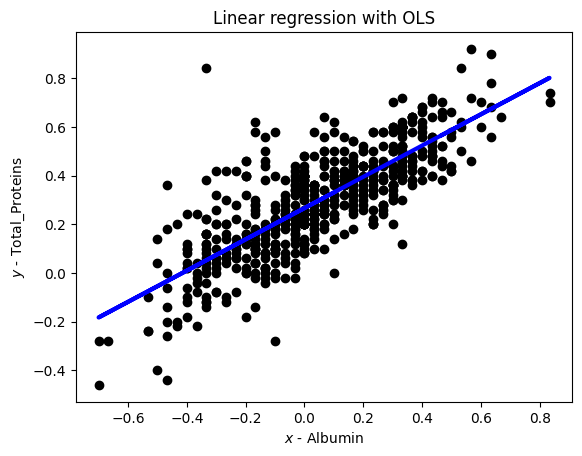

In [ ]:
def plot_linreg(x, y, beta, title):
    yhat = beta[0]*x + beta[1]
    plt.scatter(x, y,  color='black')
    plt.plot(x, yhat, color='blue', linewidth=3)
    plt.xlabel(r'$x$ - Albumin')
    plt.ylabel(r'$y$ - Total_Proteins')
    plt.title(title)
    plt.show()

beta = linreg(x,y)
plot_linreg(x, y, beta,'Linear regression with OLS')

### L3.1 Perturbed Least Squares with Gaussian Mechanism

Given that the OLS solution is a function of the four statistics $\sum_i x_i^2, \sum_i x_i, \sum_i x_i y_i$ and $\sum_i y_i$, we will first consider using the Gaussian mechanism to perturb these statistics. **How should the scale of the Gaussian noise $\sigma$ be set so as to achieve $(\epsilon,\delta)$-DP with $\delta = 1/n$? Implement as `dp_linreg_pertub` a variant of  the `linreg`function above that implements this mechanism.**

dont add noise to n and only once to sum of xi. sensitivity of each xi xiyi and then multiply by scale, and square root of number of stat.

L2 sensitivity: Δ= max change xi,y to xi',yi =|| (xi²,xi,xiy, y)-(xi²',xi',xi'y', y')||

each of this var are bteween -1 and 1 max in dimension 4--> difficult to solve

Solution: evaluate sensitivity of each coordinate (xi²,xi,xiy, y)-(xi²',xi',xi'y', y') diff between two positive numb less than one. Δ1 = 1, Δ2 = 2, Δ3 = 2, Δ4 = 2

add noise Δ = square-root 3.2² +1

= 2 sqr 3.5 --> L2 norm use it as the multiplier for the scale of the gaussian distribution

fixe delta 1/583






**Classical Result  [Theorem 3.22 of Dwork & Roth, 2014]** If $ \varepsilon \leq 1$, $(\epsilon,\delta)$-DP if
$$ \sigma \geq \frac{\Delta}{\varepsilon} \sqrt{2 \log(1.25 / \delta)} $$

But we use the alternative where we assume that $\varepsilon \leq 1$, this yields $\sigma_{\min} = \sqrt{2\log(e/\delta)/\varepsilon}$, which is the Dwork & Roth formula with a slightly bigger constant in the log. A more natural result is obtained when assuming only $\varepsilon \leq \log(1/ \delta)$, which is the "usual" regime:
$$
\sigma_{\min} = \frac{\sqrt{2}+2}{2} \frac{\sqrt{\log(1/\delta)}}{\varepsilon} \leq \frac{\sqrt{2.92\log(1/\delta)}}{\varepsilon}
$$

Since we have $x_i$ ∈ [-1;1] and $y_i$ ∈ [-1;1].

$$
\text{grad}_0 = -\frac{2}{n} \sum_{i=1}^{n} (y_i - (\beta^0 x_i + \beta^1)) x_i
$$

$$
\text{grad}_1 = -\frac{2}{n} \sum_{i=1}^{n} (y_i - (\beta^0 x_i + \beta^1))
$$

$Δ_2 = \frac{4}{n}$




In [ ]:
def dp_linreg_perturb(x, y, eps):
    """
    Performs (eps,1/n)-DP linear regression using Gauss Perturbed Least Squares.

    Parameters:
    x (numpy.ndarray): A 1D array of input features.
    y (numpy.ndarray): A 1D array of target values.
    eps (float): Privacy budget

    Returns:
    numpy.ndarray: A 1D array containing the coefficients (slope, intercept) of the linear regression model.
    """
    n = x.size
    delta = 1 / n  # Given delta = 1/n
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.matmul(x.T, y).item()
    sum_x2 = np.matmul(x.T, x).item()

    # Compute global L2 sensitivity
    sensitivity = np.sqrt(13)

    # Compute noise scale
    sigma = 1.71 * np.sqrt(np.log(1 / delta)) / eps

    # Add Gaussian noise
    sum_x2_noisy = sum_x2 + np.random.normal(0, sigma)
    sum_x_noisy = sum_x + np.random.normal(0, sigma)
    sum_xy_noisy = sum_xy + np.random.normal(0, sigma)
    sum_y_noisy = sum_y + np.random.normal(0, sigma)

    # Solve normal equations using noisy statistics
    xTx_noisy = np.array([[sum_x2_noisy, sum_x_noisy], [sum_x_noisy, n]])
    xTy_noisy = np.array([[sum_xy_noisy], [sum_y_noisy]])

    # Compute DP coefficients
    beta_gauss = np.linalg.solve(xTx_noisy, xTy_noisy)

    return beta_gauss

In the following code block, test the `dp_linreg_pertub` and compare its output with ordinary least squares.

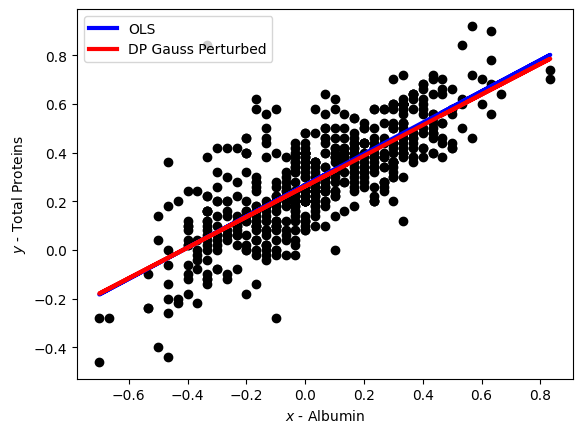

In [ ]:
def plot_compar_linreg(x, y, beta1, title1, beta2, title2):
    yhat1 = beta1[0]*x + beta1[1]
    yhat2 = beta2[0]*x + beta2[1]

    plt.scatter(x, y,  color='black')
    plt.plot(x, yhat1, color='blue', linewidth=3, label=title1)
    plt.plot(x, yhat2, color='red', linewidth=3, label=title2)
    plt.legend(loc="upper left")
    plt.xlabel(r'$x$ - Albumin')
    plt.ylabel(r'$y$ - Total Proteins')
    plt.show()

eps = 3
plot_compar_linreg(x, y, linreg(x,y), 'OLS', dp_linreg_perturb(x, y, eps), 'DP Gauss Perturbed')

To measure the accuracy of the mechanism, we compute the median root mean squared error (RMSE) over multiple runs of the mechanism.

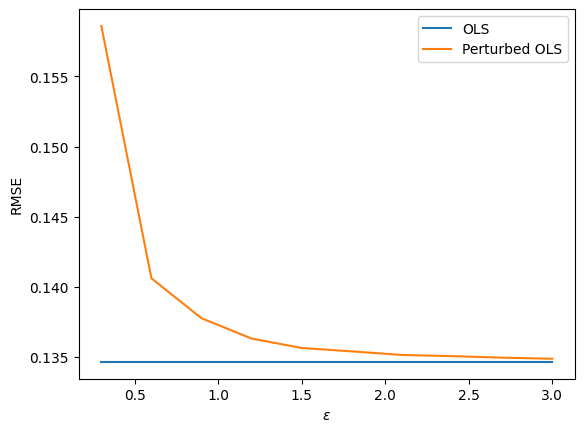

In [ ]:
num_iter = 1000
eps_arr = np.linspace(0.3, 3, num=10)

beta_ols = linreg(x,y)
yhat_ols = beta_ols[0]*x + beta_ols[1]
rmse_ols = root_mean_squared_error(y, yhat_ols)*np.ones_like(eps_arr)
rmse = np.zeros((eps_arr.size, num_iter))

for i, eps in enumerate(eps_arr):
    for j in range(num_iter):
        beta = dp_linreg_perturb(x, y, eps)
        yhat = beta[0]*x + beta[1]
        rmse[i][j] = root_mean_squared_error(y, yhat)

fig = plt.figure()
plt.plot(eps_arr, rmse_ols, label='OLS')
plt.plot(eps_arr, np.median(rmse, axis=1), label='Perturbed OLS')
plt.legend(loc="upper right")
plt.xlabel("$\epsilon$")
plt.ylabel("RMSE")
plt.show()

### L3.2 Perturbed Gradient Descent

#### Gradient Descent

For this question, we will estimate $\hat{\beta}$ using gradient descent. Recall that in gradient descent, we start from an arbitraty initialization $\hat{\beta}_0$ for $\hat{\beta}$ and update $\hat{\beta}$ using the following equation.

$\hat{\beta}_{t+1} = \hat{\beta}_t - \gamma \nabla L(\hat{\beta}_t)$,

where $t$ is the iteration number running from $1$ to $T$ (maximum number of gradient steps), $\alpha$ is the step-size and $\nabla L(\hat{\beta}_t)$ is the gradient of the loss

$L(\beta) = \frac{1}{n} \sum_{i=1}^n (y_i - (\beta_0 x + \beta_1))^2$

evaluated at $\hat{\beta}_t$.

The following code block, implements the function `linreg_gd` that computes $\beta$ using gradient descent. Note that `linreg_gd` returns a list of $\hat{\beta}_t$ for each step $t$ of the gradient descent.

In [ ]:
def linreg_gd(x, y, step_size, num_steps):
    '''
    Performs linear regression using gradient descent.
    Parameters:
    x (array of shape (n, 1)): Regressor
    y (array of shape (n, 1)): Target
    step_size (positive float): Step size for gradient descent
    num_steps (positive int (positive): Number of gradient descent steps
    Returns
    beta_list : list of length num_steps, where each element is an array of shape (2, 1)
        beta_list[t] is the estimate beta at step t
        beta_list[t][0] is the slope
        beta_list[t][1] is the y-intercept
    '''
# perturbate the gradient, dont care about step size
    n = y.size
    beta = np.zeros((2,1))
    beta_list = [beta]

    for i in range(num_steps):
        yhat = beta[0]*x + beta[1]
        grad = np.zeros_like(beta)
        grad[0] = -2*np.mean((y - yhat)*x) # bond the sensitivity of the gradient, number of iteration has an impact
        grad[1] = -2*np.mean(y - yhat)#
        beta = beta - step_size*grad
        beta_list.append(beta)

    return beta_list

compute gradient : taylor expension of first order for beta

The following code block illustrates the convergence of gradient descent.

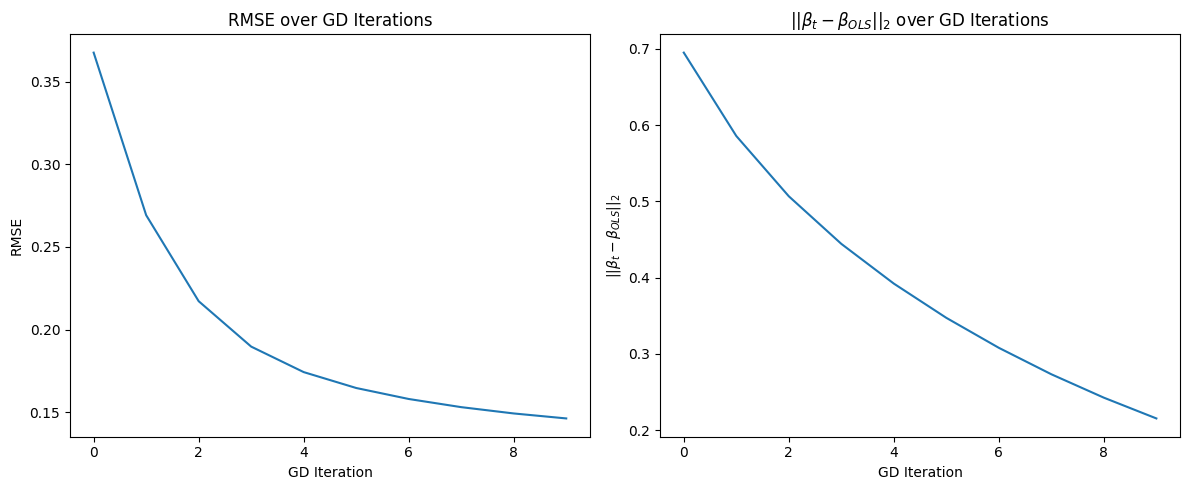

In [ ]:
num_steps = 10
step_size = 0.8

beta_ols = linreg(x, y)
beta_gd = linreg_gd(x, y, step_size, num_steps)

rmse_gd = np.zeros(num_steps)
err_beta_gd = np.zeros(num_steps)

for i in range(num_steps):
    yhat = beta_gd[i][0]*x + beta_gd[i][1]
    rmse_gd[i] = root_mean_squared_error(y, yhat)
    err_beta_gd[i] = np.linalg.norm(beta_gd[i] - beta_ols)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(rmse_gd)
ax1.set_xlabel('GD Iteration')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE over GD Iterations')

ax2.plot(err_beta_gd)
ax2.set_xlabel('GD Iteration')
ax2.set_ylabel(r'$||\beta_t - \beta_{OLS}||_2$')
ax2.set_title(r'$||\beta_t - \beta_{OLS}||_2$ over GD Iterations')

plt.tight_layout()
plt.show()

#### Q2.4 Differentially Private Gradient Descent (DP-GD)




For this question we will assume that $\hat{\beta}_0, \hat{\beta}_1 \in [-1,1]$. **Bound the $L^2$ sensitivity of the gradient under this assumption and write a function `dp_linreg_gd`(following the code of `linreg_gd`) with adds Gaussian perturbation to each gradient update and is globally $(\epsilon,\delta)$-DP with $\delta=1/n$. You should justify the sensitivity computation as well as the use of the DP budget.**

In [ ]:
def dp_linreg_gd(x,y, step_size, num_steps, eps):
    '''
    Performs (eps,1/n)-DP linear regression using Gauss Perturbed Gradient Descent.
    Parameters:
    x (array of shape (n, 1)): Regressor
    y (array of shape (n, 1)): Target
    step_size (positive float): Step size for gradient descent
    num_steps (positive int (positive): Number of gradient descent steps
    eps (positive float): Privacy budget
    Returns:
    beta_list : list of length num_steps, where each element is an array of shape (2, 1)
    '''

    # TODO: Implement (eps,1/n)-DP linear regression using Gauss Perturbed Gradient Descent
    n = y.size
    beta = np.zeros((2,1))
    beta_list = [beta]
    delta = 1/n
    sensitivity = 4 / n  # Sensitivity of gradient
    sigma = (sensitivity * np.sqrt( 2.92 *np.log(1 / delta)) / eps) * np.sqrt(num_steps)


    for i in range(num_steps):
        yhat = beta[0]*x + beta[1]
        grad = np.zeros_like(beta)
        grad[0] = -2*np.mean((y - yhat)*x) # bond the sensitivity of the gradient, number of iteration has an impact
        grad[1] = -2*np.mean(y - yhat)#

        noise = np.random.normal(0, sigma, size=grad.shape)
        grad += noise

        beta = beta - step_size * grad
        beta_list.append(beta)

    return beta_list

The following code block, test the `dp_linreg` function and plots the convergence of the sequence of linear regression parameter estimates. **You should run it a few times to get an idea of the variability**.

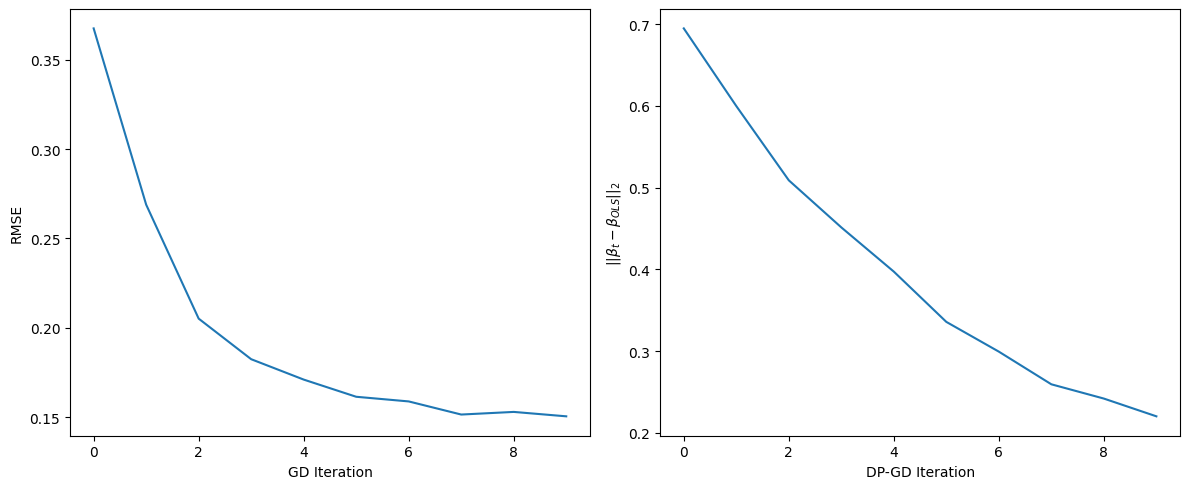

In [ ]:
eps = 5

beta_list_dpgd = dp_linreg_gd(x, y, step_size, num_steps, eps)
rmse_dpgd = np.zeros(num_steps)
err_beta_dpgd = np.zeros(num_steps)
for i in range(num_steps):
    yhat = beta_list_dpgd[i][0]*x + beta_list_dpgd[i][1]
    rmse_dpgd[i] = root_mean_squared_error(y, yhat)
    err_beta_dpgd[i] = np.linalg.norm(beta_list_dpgd[i] - beta_ols)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(rmse_dpgd)
ax1.set_xlabel('GD Iteration')
ax1.set_ylabel('RMSE')

ax2.plot(err_beta_dpgd)
ax2.set_xlabel('DP-GD Iteration')
ax2.set_ylabel(r'$||\beta_t - \beta_{OLS}||_2$')

plt.tight_layout()
plt.show()

The following code block, plots the median RMSE performance of the `dp_linreg_gd` comparing it to the (non private) values achieved by `linreg` and `lingreg_gd`.

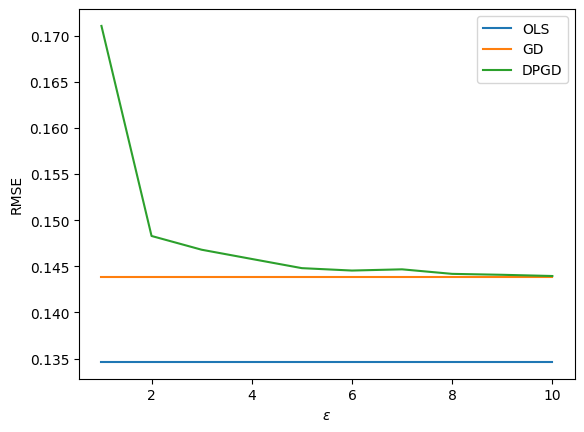

In [ ]:
beta_ols = linreg(x, y)
yhat_ols = beta_ols[0]*x + beta_ols[1]
rmse_ols = root_mean_squared_error(y, yhat_ols)*np.ones_like(eps_arr)

beta_gd = linreg_gd(x, y, step_size, num_steps)[-1]
yhat_gd = beta_gd[0]*x + beta_gd[1]
rmse_gd = root_mean_squared_error(y, yhat_gd)*np.ones_like(eps_arr)

num_iter = 100
eps_arr = np.linspace(1, 10, num=10)
rmse_dpgd = np.zeros((eps_arr.size, num_iter))

for i, eps in enumerate(eps_arr):
    for j in range(num_iter):
        beta_dpgd = dp_linreg_gd(x, y, step_size, num_steps, eps)[-1]
        yhat_dpgd = beta_dpgd[0]*x + beta_dpgd[1]
        rmse_dpgd[i][j] = root_mean_squared_error(y, yhat_dpgd)

fig = plt.figure()
plt.plot(eps_arr, rmse_ols, label='OLS')
plt.plot(eps_arr, rmse_gd, label='GD')
plt.plot(eps_arr, np.median(rmse_dpgd, axis=1), label='DPGD')
plt.legend(loc="upper right")
plt.xlabel("$\epsilon$")
plt.ylabel("RMSE")
plt.show()










Even in this simplistic example, it turns out that the maximal $L^2$ sensitivity bound that can be obtained for the gradient from our assumptions is rather pessimistic. **Modify the `dp_lingreg_gd` code so as to be able to experiment with the gradient norm-clipping alternative used in DP-SGD. Can you find a value of the clipping which provides an improved accuracy?**

**Due to the addition of noise to the gradient at each step, it is not necessarily the case that using the same constant step size scheme and number of iterations leads to optimal results in terms of accuracy. Can you come up with a better solution while keeping the same $(\epsilon,\delta=1/n)$ DP budget (say, for a typical value of $\epsilon=3$)?**

In [ ]:
import numpy as np

def linreg_gd_grad(x, y, step_size, num_steps):
    n = y.size
    beta = np.zeros((2,1))
    grad_norms = []  # Store L2 norms of gradients

    for i in range(num_steps):
        yhat = beta[0] * x + beta[1]
        grad = np.zeros_like(beta)
        grad[0] = -2 * np.mean((y - yhat) * x)
        grad[1] = -2 * np.mean(y - yhat)

        # Compute and store the L2 norm of the gradient
        grad_norm = np.linalg.norm(grad, ord=2)
        grad_norms.append(grad_norm)

        beta = beta - step_size * grad

    return grad_norms


In [ ]:
grad_norms = linreg_gd(x, y, step_size=0.8, num_steps=100)

# Select clip_norm as the 90th percentile of gradient norms
clip_norm = np.percentile(grad_norms, 90)
print(f"Recommended clip_norm: {clip_norm:.3f}")

Recommended clip_norm: 0.642


In [ ]:
import numpy as np

def dp_linreg_gd_clip(x, y, step_size, num_steps, eps, clip_norm=0.642):
    '''
    Performs (eps,1/n)-DP linear regression using Gaussian Perturbed Gradient Descent with Clipping.

    Parameters:
    x (array of shape (n, 1)): Regressor
    y (array of shape (n, 1)): Target
    step_size (float): Initial step size for gradient descent
    num_steps (int): Number of gradient descent steps
    eps (float): Privacy budget
    clip_norm (float): Clipping norm for gradients (default = 1.0)

    Returns:
    beta_list : list of length num_steps, where each element is an array of shape (2, 1)
    '''

    n = y.size
    beta = np.zeros((2,1))
    beta_list = [beta]
    delta = 1 / n
    sensitivity = clip_norm / n

    # Compute noise scale for DP guarantee
    sigma = (sensitivity * np.sqrt(2.92 * np.log(1 / delta)) / eps) * np.sqrt(num_steps)

    for i in range(num_steps):
        yhat = beta[0] * x + beta[1]

        # Compute gradient
        grad = np.zeros_like(beta)
        grad[0] = -2 * np.mean((y - yhat) * x)
        grad[1] = -2 * np.mean(y - yhat)

        grad_norm = np.linalg.norm(grad, ord=2)
        if grad_norm > clip_norm:
            grad = (clip_norm / grad_norm) * grad

        # Add Gaussian noise
        noise = np.random.normal(0, sigma)
        grad += noise

        # Gradient descent update
        beta = beta - step_size * grad
        beta_list.append(beta)

    return beta_list


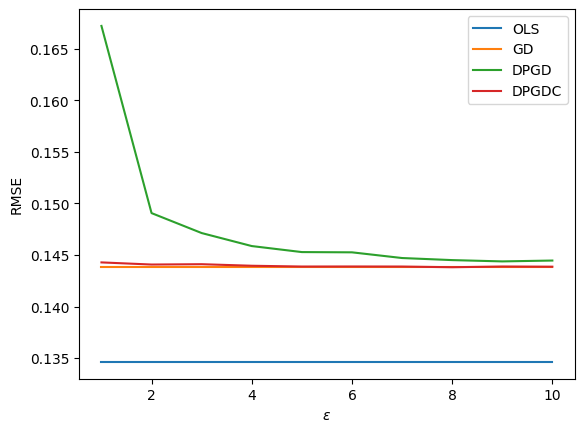

In [ ]:
beta_ols = linreg(x, y)
yhat_ols = beta_ols[0]*x + beta_ols[1]
rmse_ols = root_mean_squared_error(y, yhat_ols)*np.ones_like(eps_arr)

beta_gd = linreg_gd(x, y, step_size, num_steps)[-1]
yhat_gd = beta_gd[0]*x + beta_gd[1]
rmse_gd = root_mean_squared_error(y, yhat_gd)*np.ones_like(eps_arr)

num_iter = 100
eps_arr = np.linspace(1, 10, num=10)
rmse_dpgd = np.zeros((eps_arr.size, num_iter))
rmse_cdpgd = np.zeros((eps_arr.size, num_iter))

for i, eps in enumerate(eps_arr):
    for j in range(num_iter):
        beta_dpgd = dp_linreg_gd(x, y, step_size, num_steps, eps)[-1]
        yhat_dpgd = beta_dpgd[0]*x + beta_dpgd[1]
        rmse_dpgd[i][j] = root_mean_squared_error(y, yhat_dpgd)
        beta_cdpgd = dp_linreg_gd_clip(x, y, step_size, num_steps, eps)[-1]
        yhat_cdpgd = beta_cdpgd[0]*x + beta_cdpgd[1]
        rmse_cdpgd[i][j] = root_mean_squared_error(y, yhat_cdpgd)

fig = plt.figure()
plt.plot(eps_arr, rmse_ols, label='OLS')
plt.plot(eps_arr, rmse_gd, label='GD')
plt.plot(eps_arr, np.median(rmse_dpgd, axis=1), label='DPGD')
plt.plot(eps_arr, np.median(rmse_cdpgd, axis=1), label='DPGDC')
plt.legend(loc="upper right")
plt.xlabel("$\epsilon$")
plt.ylabel("RMSE")
plt.show()

We can see that when we clip we get much better results than without. For example with a privacy budget of ϵ = 3, we get similar results than gradient descent and much better results than DP-Gradient Descent.

In [75]:

def step_dp_linreg_gd(x, y, step_size, num_steps, eps):
    '''
    Performs (eps,1/n)-DP linear regression using Gauss Perturbed Gradient Descent with adaptive step size.

    Parameters:
    x (array of shape (n, 1)): Regressor
    y (array of shape (n, 1)): Target
    step_size (positive float): Initial step size for gradient descent
    num_steps (positive int): Number of gradient descent steps
    eps (positive float): Privacy budget

    Returns:
    beta_list : list of length num_steps, where each element is an array of shape (2, 1)
    '''

    n = y.size
    beta = np.zeros((2, 1))
    beta_list = [beta]
    delta = 1/n
    sensitivity = 4 / n  # Sensitivity of gradient
    sigma = (sensitivity * np.sqrt(2.92 * np.log(1 / delta)) / eps) * np.sqrt(num_steps)

    for t in range(1, num_steps + 1):
        yhat = beta[0] * x + beta[1]
        grad = np.zeros_like(beta)
        grad[0] = -2 * np.mean((y - yhat) * x)
        grad[1] = -2 * np.mean(y - yhat)

        noise = np.random.normal(0, sigma, size=grad.shape)
        grad += noise

        # Adaptive step size: decrease over time
        eta_t = step_size / (1+0.001 * t)  # Slower decay

        beta = beta - eta_t * grad
        beta_list.append(beta)

    return beta_list


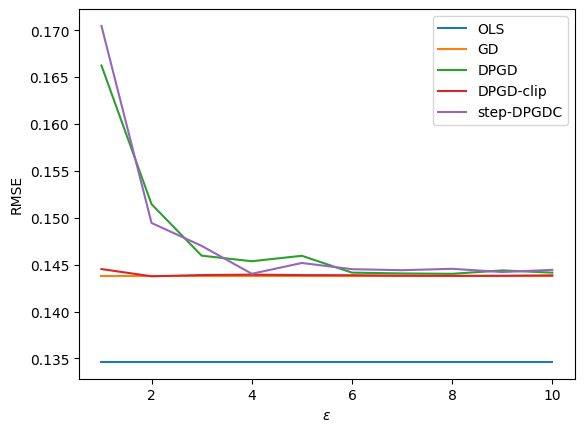

In [77]:
beta_ols = linreg(x, y)
yhat_ols = beta_ols[0]*x + beta_ols[1]
rmse_ols = root_mean_squared_error(y, yhat_ols)*np.ones_like(eps_arr)

beta_gd = linreg_gd(x, y, step_size, num_steps)[-1]
yhat_gd = beta_gd[0]*x + beta_gd[1]
rmse_gd = root_mean_squared_error(y, yhat_gd)*np.ones_like(eps_arr)

num_iter = 100
eps_arr = np.linspace(1, 10, num=10)
rmse_dpgd = np.zeros((eps_arr.size, num_iter))
rmse_cdpgd = np.zeros((eps_arr.size, num_iter))
rmse_step_dpgd = np.zeros((eps_arr.size, num_iter))

for i, eps in enumerate(eps_arr):
    for j in range(num_iter):
        beta_dpgd = dp_linreg_gd(x, y, step_size, num_steps, eps)[-1]
        yhat_dpgd = beta_dpgd[0]*x + beta_dpgd[1]
        rmse_dpgd[i][j] = root_mean_squared_error(y, yhat_dpgd)
        beta_cdpgd = dp_linreg_gd_clip(x, y, step_size, num_steps, eps)[-1]
        yhat_cdpgd = beta_cdpgd[0]*x + beta_cdpgd[1]
        rmse_cdpgd[i][j] = root_mean_squared_error(y, yhat_cdpgd)
        beta_step_dpgd = step_dp_linreg_gd(x, y, step_size, num_steps, eps)[-1]
        yhat_step_dpgd = beta_step_dpgd[0]*x + beta_step_dpgd[1]
        rmse_step_dpgd[i][j] = root_mean_squared_error(y, yhat_step_dpgd)

fig = plt.figure()
plt.plot(eps_arr, rmse_ols, label='OLS')
plt.plot(eps_arr, rmse_gd, label='GD')
plt.plot(eps_arr, np.median(rmse_dpgd, axis=1), label='DPGD')
plt.plot(eps_arr, np.median(rmse_cdpgd, axis=1), label='DPGD-clip')
plt.plot(eps_arr, np.median(rmse_step_dpgd, axis=1), label='step-DPGDC')
plt.legend(loc="upper right")
plt.xlabel("$\epsilon$")
plt.ylabel("RMSE")
plt.show()

We can see that when modifying the step-size and reducing it we get similar results than the DPGP.